# Stock Price Prediction Using Random Forest

In this notebook, we will be exploring the performance of the random forest classifier on the S&P500 stock data.

## Notas

Preciso de 15 dias de dados antes de 2010 para calcular umas coisas, ou então removo aproximadamente 13 ou 14 colunas.

Sources:
 - [Exponential Smoothing](https://medium.com/@criesin.90days/stock-price-forecasting-with-exponential-smoothing-an-analytical-project-report-380c7ca694a8)
 - [The Random Forest Model for Analyzing and Forecasting the US Stock Market in the Context of Smart Finance](https://arxiv.org/pdf/2402.17194)

In [36]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
# Suppress warnings for cleaner output
import warnings

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
import pandas as pd
import numpy as np
import itertools
from tqdm import tqdm


import matplotlib.pyplot as plt

# Data Preprocessing

We decided to follow the paper's approach and apply **Exponential Smoothing** to our data, which assigns greater weight to more recent examples. 

We do this because the stock prices are more likely to follow recent patterns, rather than patterns from years ago.

In [37]:
df_apple = pd.read_csv('./clean_csvs/AAPL.csv')
df_apple.head()

,Date,AdjClose,Close,High,Low,Open,Volume
0,2010-01-04,6.447411,7.643214,7.660714,7.585000,7.622500,493729600
1,2010-01-05,6.458559,7.656429,7.699643,7.616071,7.664286,601904800
2,2010-01-06,6.355826,7.534643,7.686786,7.526786,7.656429,552160000
3,2010-01-07,6.344076,7.520714,7.571429,7.466071,7.562500,477131200
4,2010-01-08,6.386254,7.570714,7.571429,7.466429,7.510714,447610800


In order to determine the alpha and beta values for exponential smoothing, we decided to follow [this website's approach](https://medium.com/@criesin.90days/stock-price-forecasting-with-exponential-smoothing-an-analytical-project-report-380c7ca694a8), by using **The Ordinary Least Squares (OLS) method**.

# Needs Fixing!

---

In order to do so, we will be using the **`statsmodels`** library, which is commonly imported as **`sm`**. This library provides tools for statistical modeling, including Ordinary Least Squares (OLS) regression, which we'll use to calculate **alpha** and **beta**.

Specifically:

1. **Alpha** and **Beta** are calculated through a **linear regression analysis**:
   - **Alpha** represents the intercept of the regression line. It quantifies the excess return of the stock or portfolio that is independent of market movements (e.g., a measure of performance beyond what the market explains).
   - **Beta** is the slope of the regression line, measuring how sensitive the stock or portfolio is to market changes. A beta of 1 implies the stock moves in line with the market, while a beta greater than or less than 1 indicates more or less sensitivity, respectively.

2. Using the `statsmodels` module:
   - We first construct the independent variable **\( X \)**, which represents the lagged adjusted close prices (market or benchmark values). To account for the intercept (alpha), we use **`sm.add_constant(X)`**, which adds a constant column of ones to the dataset.
   - The dependent variable **\( Y \)** represents the **returns**, calculated as the percentage change in adjusted close prices of the stock or portfolio.

3. **Modeling with OLS**:
   - The **`sm.OLS(Y, X).fit()`** function sets up an Ordinary Least Squares regression, where:
     - \( Y \) (dependent variable) is modeled as a linear function of \( X \) (independent variable plus constant).
   - The `.fit()` method runs the regression and calculates the coefficients:
     - The intercept (\( \alpha \)) is stored in `model.params[0]`.
     - The slope (\( \beta \)) is stored in `model.params[1]`.

Thus, by running this regression analysis with `statsmodels`, we estimate the **alpha** (excess returns) and **beta** (sensitivity to market movements) for the stock or portfolio relative to the market or another benchmark.

---


 This snippet illustrates the process:

In [38]:
df_apple_smooth = df_apple.copy()

In [39]:
warnings.filterwarnings('ignore')

returns = (df_apple_smooth["Close"] - df_apple_smooth["Close"].shift(1)) / df_apple_smooth["Close"].shift(1)

# Regression Analysis and Estimating Alpha and Beta
Y = returns.dropna()
X = df_apple_smooth["Close"].shift(1).dropna()

#  Include the intercept term in the regression
X = sm.add_constant(X)  

model = sm.OLS(Y, X).fit()
alpha = model.params[0]
beta = model.params[1]

In [40]:
print(f"Alpha: {alpha}    |    Beta: {beta}")

Alpha: 0.0012738698637192818    |    Beta: -2.91906269905718e-06


 - **alpha**: determines how responsive the smoothed values are to recent price changes
 - **beta**: adjusts the trend component to improve forecast accuracy
 - **periods**: specifies how far into the future we want to forecast (in our case, 1 month with 31 days)

In [41]:
def exponential_smoothing(data, alpha, beta):
    n = len(data)
    smoothed_values = [data[0]]

    # Smoothing the historical data
    for i in range(1, n):
        smoothed = alpha * data[i] + (1 - alpha) * (smoothed_values[i - 1] + beta * (data[i] - smoothed_values[i - 1]))
        smoothed_values.append(smoothed)
    
    return smoothed_values


---

### **2. Undoing Smoothing After Predictions**
Smoothing is inherently a lossy operation; the original data cannot be exactly reconstructed after smoothing. However, you can approximate the **"unsmoothed" predicted values** by reversing the smoothing formula.

#### Reverse the Smoothing Formula
The exponential smoothing formula for $ smoothed[i] $ is:

<center>

$
smoothed[i] = \alpha \cdot data[i] + (1 - \alpha) \cdot (smoothed[i-1] + \beta \cdot (data[i] - smoothed[i-1]))
$

</center>

To approximate $ data[i] $ (original value) from $ smoothed[i] $, rearrange the formula:

<center>

$
data[i] \approx \frac{smoothed[i] - (1 - \alpha) \cdot (smoothed[i-1] + \beta \cdot (data[i-1] - smoothed[i-1]))}{\alpha}
$

</center>

Since $ data[i-1] $ isn't directly available from predictions, use the smoothed predictions recursively to approximate the original data. Here's how you can implement the process:

---

In [42]:
def undo_exponential_smoothing(smoothed_values, alpha, beta):
    n = len(smoothed_values)
    original_data = [smoothed_values[0]]  # Start with the first smoothed value

    for i in range(1, n):
        # Reverse the smoothing formula
        approx_original = (smoothed_values[i] - (1 - alpha) * (smoothed_values[i-1])) / alpha
        original_data.append(approx_original)

    return original_data

# EXPONENTIAL SMOOTHING NOT CORRECTLY IMPLEMENTED

### Obtaining Recommended Features

<center>

![](./images/features_paper1.png)

</center>

 - **RSI (Relative Strength Index)**: The RSI measures the speed and change of price movements. It oscillates between 0 and 100 and is calculated over a specific period (e.g., 14 days).

<center>

$
RSI = 100 - \frac{100}{1 + RS}
$      

</center>

<center>

where

</center>

<center>

$
RS = \frac{\text{Average Gain over N periods}}{\text{Average Loss over N periods}}
$

</center>

In [43]:
def addRSI(df):    

    window_length = 14  # Standard Value
    
    # Calculate price differences
    delta = df['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate exponential moving averages of gains and losses
    avg_gain = gain.rolling(window=window_length, min_periods=1).mean()
    avg_loss = loss.rolling(window=window_length, min_periods=1).mean()

    # Calculate RSI
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))


 - **Stochastic Oscillator**:
Measures the closing price relative to the price range over a period of time (e.g., 14 days).

<center>

$
\%K = \frac{\text{Close} - \text{Low}_N}{\text{High}_N - \text{Low}_N} \times 100
$

</center>


In [44]:
def addK(df):
    n = 14  # Look-back period
    df['%K'] = ((df['Close'] - df['Low'].rolling(n).min()) / (df['High'].rolling(n).max() - df['Low'].rolling(n).min())) * 100

 - **Williams %R**:
Similar to the stochastic oscillator but inverted and shifted.

<center>

$
\%R = \frac{\text{High}_N - \text{Close}}{\text{High}_N - \text{Low}_N} \times -100
$

</center>


In [45]:
def addR(df):
    n = 14
    highn_close = (df['High'].rolling(n).max() - df['Close'])
    highn_lown = (df['High'].rolling(n).max() - df['Low'].rolling(n).min())
    df['%R'] = (highn_close / highn_lown) * (-100)

 - **MACD (Moving Average Convergence Divergence)**:
Measures the difference between a fast and a slow exponential moving average (EMA).

In [46]:
def addMACD(df):
    fast_period = 12
    slow_period = 26
    signal_period = 9

    df['EMA_fast'] = df['Close'].ewm(span=fast_period, adjust=False).mean()
    df['EMA_slow'] = df['Close'].ewm(span=slow_period, adjust=False).mean()
    df['MACD'] = df['EMA_fast'] - df['EMA_slow']
    df['Signal_Line'] = df['MACD'].ewm(span=signal_period, adjust=False).mean()

 -  **Price Rate of Change (ROC)**:
Measures the percentage change in price over a given time.

<center>

$
ROC = \frac{\text{Close}_t - \text{Close}_{t-n}}{\text{Close}_{t-n}} \times 100
$

</center>


In [47]:
def addROC(df):
    n = 14  # Period
    df['ROC'] = (df['Close'] - df['Close'].shift(n)) / df['Close'].shift(n) * 100

 - **On-Balance Volume (OBV)**:
Measures buying and selling pressure using volume.

In [48]:
def addOBV(df):
    df['Direction'] = df['Close'].diff().apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    df['OBV'] = (df['Direction'] * df['Volume']).cumsum()

### Adding Paper Recommended Features

In order to facilitate adding features to any dataframe, we decided to build this function, which already **removes NaN values automatically**. We have 2 different options to do so:
 - Removing the first 14 rows of the dataframe, as they are entered due to the **look-back period**, which is never higher than 14.
 - Removing only 2 rows, but deleting the `%K`, `%R` and `ROC` columns entirely.

We decided to implement this possibility, in case dimentionality is a problem in the future.

In [49]:
def addFeatures(df, rows=True):
    addRSI(df)
    addK(df)
    addR(df)
    addMACD(df)
    addROC(df)
    addOBV(df)

    # Removes first 14 rows of the dataset 
    if rows: df.drop(index=range(0, 14), inplace=True)

    # Removes first 2 rows of the dataset, and the `%K`, `%R` and `ROC` columns
    else: 
        df.drop(index=range(0, 2), inplace=True)
        df.drop(columns=['ROC','%K', '%R'], inplace=True)

In [50]:
addFeatures(df_apple, False)

df_apple.head(15)

,Date,AdjClose,Close,High,Low,Open,Volume,RSI,EMA_fast,EMA_slow,MACD,Signal_Line,Direction,OBV
2,2010-01-06,6.355826,7.534643,7.686786,7.526786,7.656429,552160000,9.788567,7.628231,7.636078,-0.007847,-0.001401,-1,49744800
3,2010-01-07,6.344076,7.520714,7.571429,7.466071,7.562500,477131200,8.873044,7.611690,7.627533,-0.015843,-0.004289,-1,-427386400
4,2010-01-08,6.386254,7.570714,7.571429,7.466429,7.510714,447610800,31.777433,7.605386,7.623324,-0.017938,-0.007019,1,20224400
5,2010-01-11,6.329920,7.503929,7.607143,7.444643,7.600000,462229600,23.790476,7.589777,7.614480,-0.024703,-0.010556,-1,-442005200
6,2010-01-12,6.257915,7.418571,7.491786,7.372143,7.471071,594459600,18.006175,7.563438,7.599968,-0.036530,-0.015751,-1,-1036464800
7,2010-01-13,6.346186,7.523214,7.533214,7.289286,7.423929,605892000,36.833856,7.557250,7.594283,-0.037033,-0.020007,1,-430572800
8,2010-01-14,6.309431,7.479643,7.516429,7.465000,7.503929,432894000,33.619494,7.545310,7.585791,-0.040481,-0.024102,-1,-863466800
9,2010-01-15,6.203987,7.354643,7.557143,7.352500,7.533214,594067600,26.887912,7.515977,7.568669,-0.052692,-0.029820,-1,-1457534400
10,2010-01-19,6.478441,7.680000,7.685357,7.401429,7.440357,730007600,51.936811,7.541211,7.576915,-0.035704,-0.030997,1,-727526800
11,2010-01-20,6.378724,7.561786,7.698214,7.482143,7.675357,612152800,46.187316,7.544376,7.575795,-0.031418,-0.031081,-1,-1339679600


---

## Introduction to Model Development

In [51]:
# Convert Date to datetime and sort by Date
df_apple['Date'] = pd.to_datetime(df_apple['Date'])
df_apple = df_apple.sort_values(by='Date')

# Removing adjusted close from training data
df_apple = df_apple.drop(columns=['AdjClose'])

Because we cannot pass `datetime` objects into the random forest, we need to create new columns to represent day, month and year, thus preserving sequential importance.

In [52]:
# Extract temporal features
df_apple['Day'] = df_apple['Date'].dt.day
df_apple['Month'] = df_apple['Date'].dt.month
df_apple['Year'] = df_apple['Date'].dt.year

In [53]:
df_apple.head()

,Date,Close,High,Low,Open,Volume,RSI,EMA_fast,EMA_slow,MACD,Signal_Line,Direction,OBV,Day,Month,Year
2,2010-01-06,7.534643,7.686786,7.526786,7.656429,552160000,9.788567,7.628231,7.636078,-0.007847,-0.001401,-1,49744800,6,1,2010
3,2010-01-07,7.520714,7.571429,7.466071,7.562500,477131200,8.873044,7.611690,7.627533,-0.015843,-0.004289,-1,-427386400,7,1,2010
4,2010-01-08,7.570714,7.571429,7.466429,7.510714,447610800,31.777433,7.605386,7.623324,-0.017938,-0.007019,1,20224400,8,1,2010
5,2010-01-11,7.503929,7.607143,7.444643,7.600000,462229600,23.790476,7.589777,7.614480,-0.024703,-0.010556,-1,-442005200,11,1,2010
6,2010-01-12,7.418571,7.491786,7.372143,7.471071,594459600,18.006175,7.563438,7.599968,-0.036530,-0.015751,-1,-1036464800,12,1,2010


In [54]:
# Train with 2010 - 2023
train_data = df_apple[(df_apple['Date'] >= '2010-01-01') & (df_apple['Date'] < '2024-01-01')]

# Test with January 2024
test_data = df_apple[(df_apple['Date'] >= '2024-01-01') & (df_apple['Date'] < '2024-02-01')]

# Separates train_data into X and y
X_train = train_data.drop(columns=['Date','Close', 'High', 'Low', 'Open'])
y_train = train_data['Close']

In [55]:
X_train.head()

,Volume,RSI,EMA_fast,EMA_slow,MACD,Signal_Line,Direction,OBV,Day,Month,Year
2,552160000,9.788567,7.628231,7.636078,-0.007847,-0.001401,-1,49744800,6,1,2010
3,477131200,8.873044,7.611690,7.627533,-0.015843,-0.004289,-1,-427386400,7,1,2010
4,447610800,31.777433,7.605386,7.623324,-0.017938,-0.007019,1,20224400,8,1,2010
5,462229600,23.790476,7.589777,7.614480,-0.024703,-0.010556,-1,-442005200,11,1,2010
6,594459600,18.006175,7.563438,7.599968,-0.036530,-0.015751,-1,-1036464800,12,1,2010


In [56]:
y_train.head()

2    7.534643
3    7.520714
4    7.570714
5    7.503929
6    7.418571
Name: Close, dtype: float64

In [57]:
# Separates test_data into X and y
X_test = test_data.drop(columns=['Date','Close', 'High', 'Low', 'Open'])
y_test = test_data['Close']

# Keep for reference during performance analysis
y_test_dates = test_data['Date']  

In [58]:
X_test.head()

,Volume,RSI,EMA_fast,EMA_slow,MACD,Signal_Line,Direction,OBV,Day,Month,Year
3522,82488700,31.663452,192.642575,191.860181,0.782394,2.096536,-1,16138533900,2,1,2024
3523,58414500,24.387836,191.351410,191.296464,0.054946,1.688218,-1,16080119400,3,1,2024
3524,71983600,8.867228,189.898886,190.601171,-0.702285,1.210118,-1,16008135800,4,1,2024
3525,62303300,7.864614,188.557518,189.903306,-1.345788,0.698936,-1,15945832500,5,1,2024
3526,59144500,24.905980,188.096361,189.581579,-1.485219,0.262105,1,16004977000,8,1,2024


In [59]:
y_test_dates.head()

3522   2024-01-02
3523   2024-01-03
3524   2024-01-04
3525   2024-01-05
3526   2024-01-08
Name: Date, dtype: datetime64[ns]

In [60]:
y_test.head()

3522    185.639999
3523    184.250000
3524    181.910004
3525    181.179993
3526    185.559998
Name: Close, dtype: float64

In [61]:
# Initialize and train the Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict for January 2024
predictions = model.predict(X_test)

# Create dataframe with results
results = pd.DataFrame({'Date': y_test_dates, 'Predicted_Close': predictions})

In [62]:
results.head()

,Date,Predicted_Close
3522,2024-01-02,187.588002
3523,2024-01-03,186.015203
3524,2024-01-04,185.138903
3525,2024-01-05,183.253803
3526,2024-01-08,183.663302


In [63]:
# Evaluate if actual January 2024 prices are available
if 'Close' in test_data.columns:
    y_test = test_data['Close']
    rmse = root_mean_squared_error(y_test, predictions)
    print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 2.8565167846781527


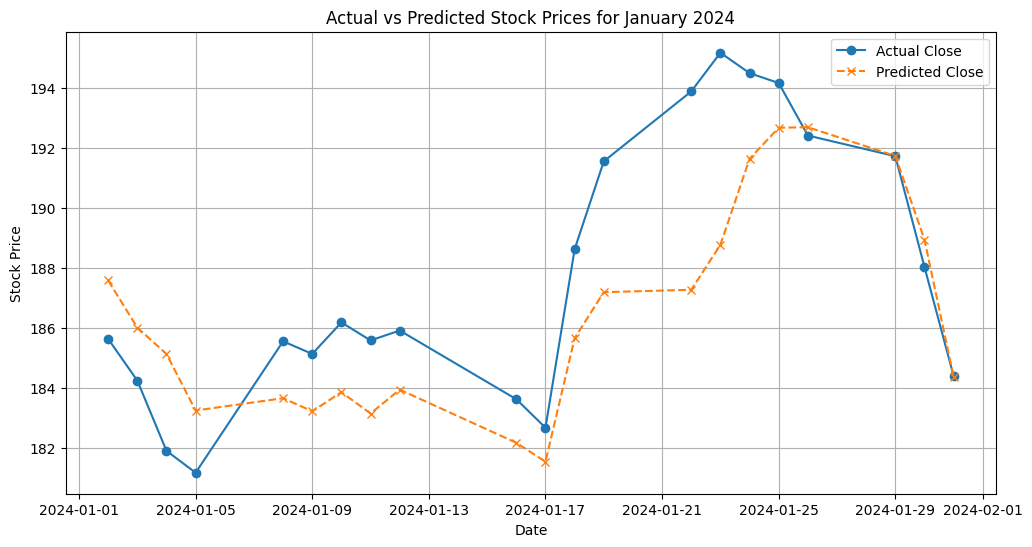

In [64]:
# Plot actual vs predicted without merging the dataframes
plt.figure(figsize=(12, 6))

# Plot actual prices
plt.plot(test_data['Date'], test_data['Close'], label='Actual Close', marker='o')

# Plot predicted prices
plt.plot(results['Date'], results['Predicted_Close'], label='Predicted Close', linestyle='--', marker='x')

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices for January 2024')
plt.legend()
plt.grid(True)
plt.show()


![](before.jpg)

### What if we had the best combination of columns?

``` py
# Prepare the data
columns_to_consider = Feature_list = ['RSI','EMA_fast','EMA_slow','MACD','Signal_Line','Direction','OBV']
best_rmse = float('inf')  # Initialize a large RMSE value
best_combination = None
best_predictions = None
final_dataframe = None

# Iterate over all possible feature combinations

for r in tqdm(range(1, len(columns_to_consider) + 1), desc="Feature Set Size"):  # Combinations of size 1 to n
    for combination in itertools.combinations(columns_to_consider, r):
        # Select the current combination of features
        selected_features = list(combination)
        X_train_subset = X_train[selected_features]
        X_test_subset = X_test[selected_features]

        # Train the Random Forest model
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train_subset, y_train)

        # Make predictions for January 2024
        predictions = model.predict(X_test_subset)

        # Evaluate RMSE if actual prices are available
        if 'Close' in test_data.columns:
            y_test = test_data['Close']
            rmse = root_mean_squared_error(y_test, predictions)

            # Update the best combination if the RMSE improves
            if rmse < best_rmse:
                best_rmse = rmse
                best_combination = selected_features
                best_predictions = predictions
                final_dataframe = X_train_subset  # Save the DataFrame with selected features

# Print the best results
print(f"Best RMSE: {best_rmse}")
print(f"Best Feature Combination: {best_combination}")

# Save predictions
pd.DataFrame({'Date': test_data['Date'], 'Predicted_Close': best_predictions}).to_csv('predictions.csv', index=False)
```

```py       

with open('best_combination.pkl', 'wb') as f:
    pickle.dump(best_combination, f)

with open('best_predictions.pkl', 'wb') as f:
    pickle.dump(best_predictions, f)

```    